# Sounding Bass Demo

This notebook demonstrates the `add_sounding_bass` function from `music_df.add_feature`.

For each note, `add_sounding_bass` identifies the **lowest-pitched note sounding at that note's onset**.
We visualize this by drawing lines from each note down to its sounding bass note on a piano roll.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

from music_df.add_feature import add_sounding_bass
from music_df.plot import plot_piano_roll
from music_df.read_csv import read_csv as mdf_read_csv

In [4]:
EXAMPLE_DIR = Path("../tests/resources/example_dfs")

BASS_COLOR = "#2E86AB"  # Blue for bass notes
NON_BASS_COLOR = "#A23B72"  # Magenta for non-bass notes
LINE_COLOR = "#888888"  # Gray for connecting lines


def load_first_n_bars(notes_path: Path, n_bars: int = 8) -> pd.DataFrame:
    """Load notes and filter to first n bars."""
    notes_df = mdf_read_csv(str(notes_path)).reset_index()

    bars = notes_df[notes_df["type"] == "bar"]["onset"].sort_values()
    if len(bars) > n_bars:
        cutoff = bars.iloc[n_bars]
    else:
        cutoff = notes_df["release"].max()

    return notes_df[notes_df["onset"] < cutoff].copy()


def plot_sounding_bass(
    df: pd.DataFrame,
    title: str | None = None,
    figsize: tuple[int, int] = (14, 6),
) -> None:
    """Plot piano roll with lines connecting each note to its sounding bass."""
    df = add_sounding_bass(df)
    notes = df[df.type == "note"].copy()

    is_bass = notes.index == notes["sounding_bass_idx"]
    colors = [BASS_COLOR if b else NON_BASS_COLOR for b in is_bass]

    fig, ax = plt.subplots(figsize=figsize)
    plot_piano_roll(notes, colors=colors, ax=ax, barlines=True)

    for idx, row in notes.iterrows():
        bass_idx = row["sounding_bass_idx"]
        if pd.notna(bass_idx) and bass_idx != idx:
            bass_row = df.loc[bass_idx]
            x = row["onset"]
            y_top = row["pitch"] + 0.5
            y_bottom = bass_row["pitch"] + 0.5
            ax.plot(
                [x, x], [y_top, y_bottom],
                color=LINE_COLOR, linewidth=0.8, linestyle="-", zorder=2.5, alpha=0.6
            )

    if title:
        ax.set_title(title)

    ax.legend(
        handles=[
            plt.Rectangle((0, 0), 1, 1, fc=BASS_COLOR, label="Bass note"),
            plt.Rectangle((0, 0), 1, 1, fc=NON_BASS_COLOR, label="Non-bass note"),
        ],
        loc="upper right",
    )
    plt.tight_layout()
    plt.show()

## Bach Chorale

In a four-part chorale, the bass voice typically sustains through chord changes.
Notice how the vertical lines connect upper voices down to the bass.

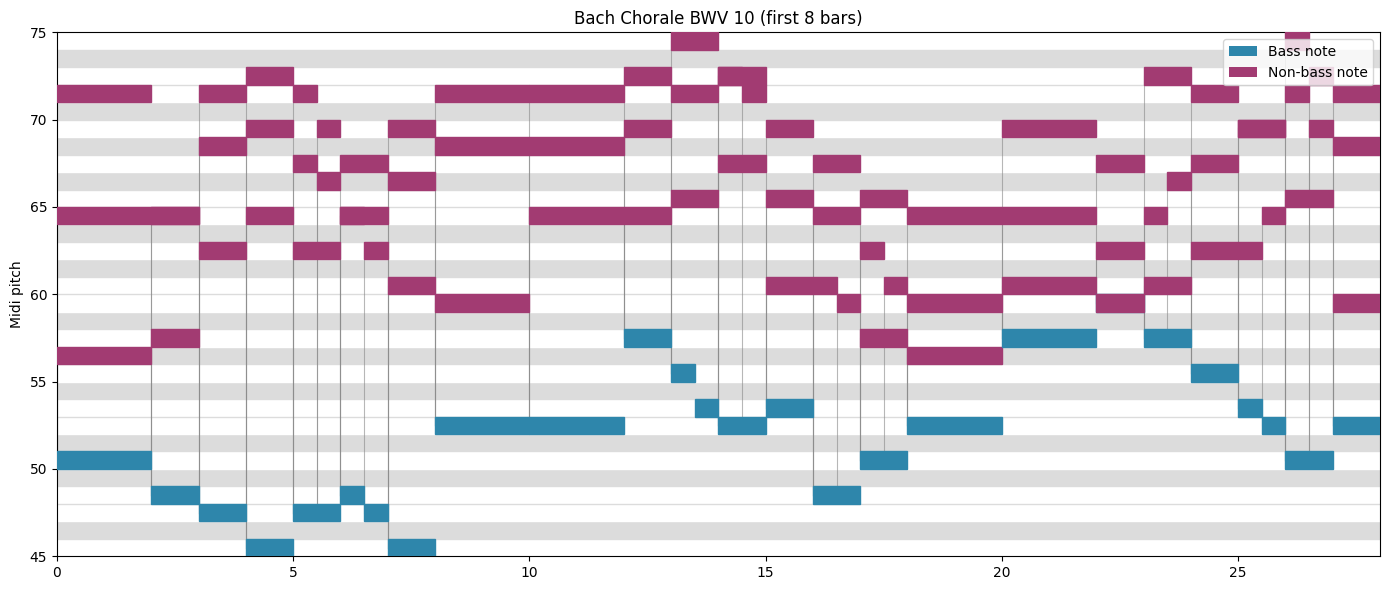

In [5]:
bach_df = load_first_n_bars(EXAMPLE_DIR / "Bach,_Johann_Sebastian_Chorales_010_notes.csv")
plot_sounding_bass(bach_df, title="Bach Chorale BWV 10 (first 8 bars)")

## Mozart Piano Sonata K. 330

In piano music, the bass often moves more frequently with Alberti bass patterns
or other accompaniment figures.

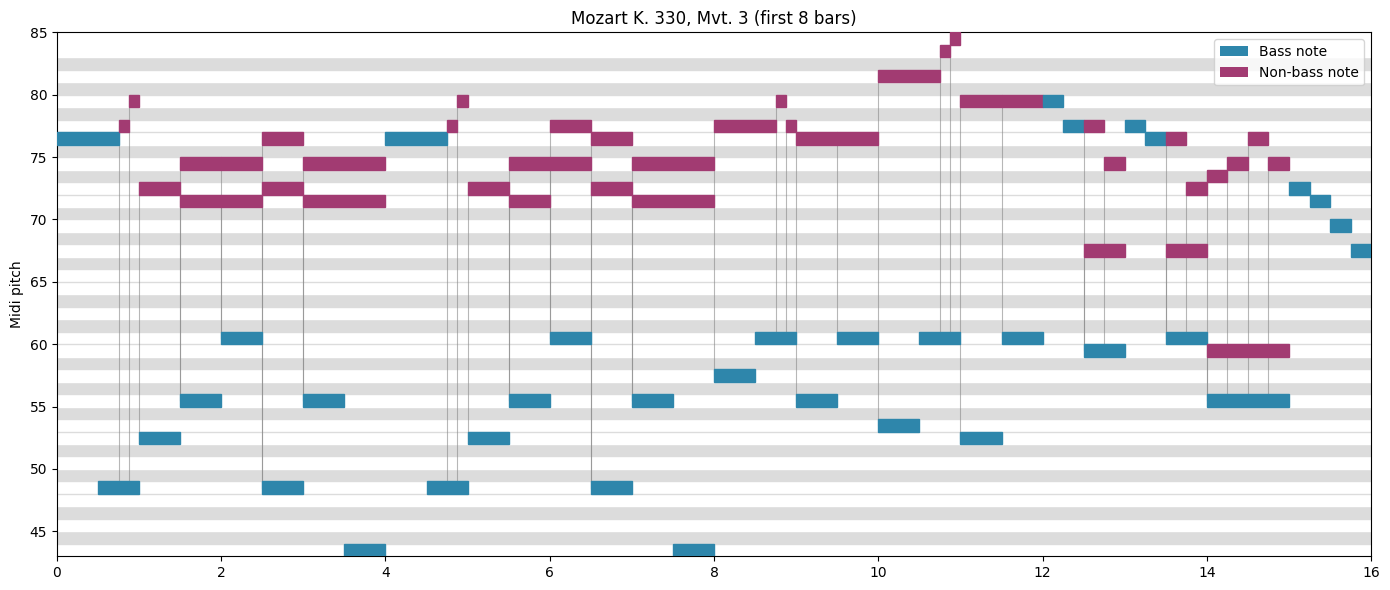

In [6]:
mozart_df = load_first_n_bars(EXAMPLE_DIR / "K330-3_notes.csv")
plot_sounding_bass(mozart_df, title="Mozart K. 330, Mvt. 3 (first 8 bars)")

## Grieg Lyric Piece Op. 12 No. 1

Romantic piano music often features more complex textures with sustained bass notes
and arpeggiated figures above.

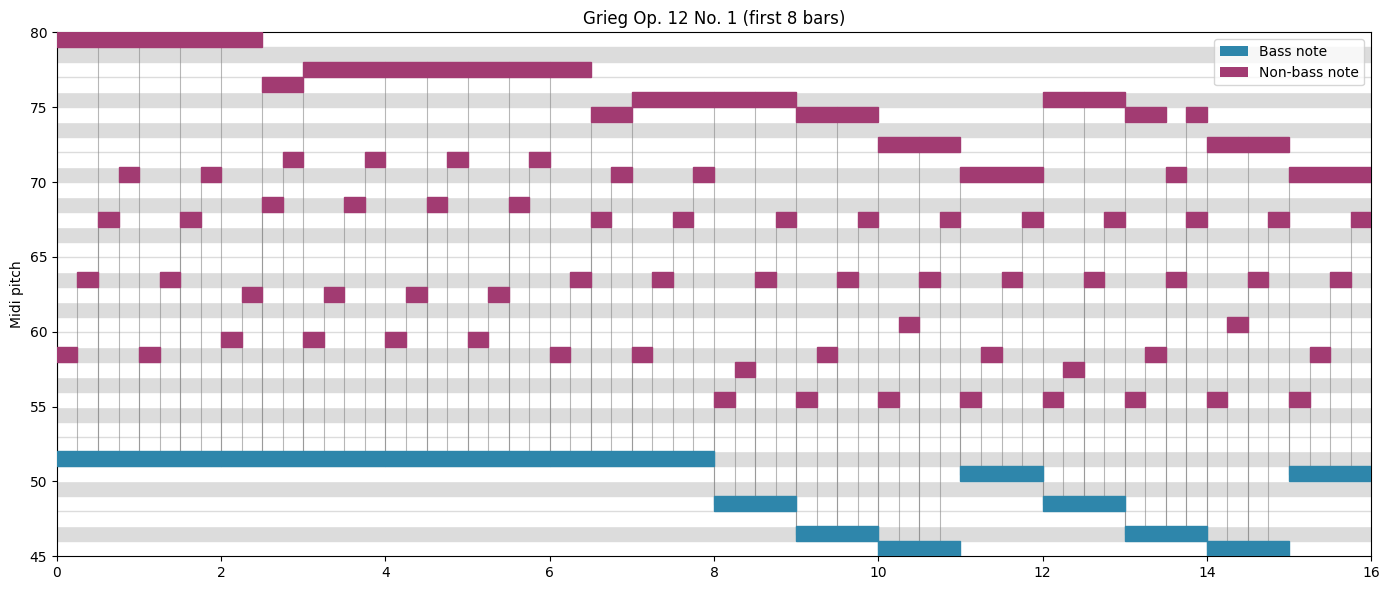

In [7]:
grieg_df = load_first_n_bars(EXAMPLE_DIR / "op12n01_notes.csv")
plot_sounding_bass(grieg_df, title="Grieg Op. 12 No. 1 (first 8 bars)")